Reference for how to install R packages [here](https://towardsdatascience.com/how-to-install-packages-in-r-google-colab-423e8928cd2e).

This is from [this](https://www.r-bloggers.com/2015/10/modelling-dependence-with-copulas-in-r/) r-bloggers post.

In [ ]:
system('sudo apt-get install -y libgsl0-dev', intern=TRUE)
install.packages('copula')
library(copula)

[1] "Reading package lists..."                                       
[2] "Building dependency tree..."                                    
[3] "Reading state information..."                                   
[4] "libgsl-dev is already the newest version (2.4+dfsg-6)."         
[5] "0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded."

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages('evir')
library('evir')
install.packages('quantmod')
library('quantmod')
install.packages('VineCopula')
library('VineCopula')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘VineCopula’


The following object is masked from ‘package:copula’:

    pobs




In [ ]:
getSymbols("CREE", from="2010-01-02", to="2021-01-06", src="yahoo", auto.assign = getOption('loadSymbols.auto.assign',TRUE))
getSymbols("GOOGL", from="2010-01-02", to="2021-01-06", src="yahoo", auto.assign = getOption('loadSymbols.auto.assign',TRUE))

‘getSymbols’ currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
‘loadSymbols’ to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.




[1] "CREE"

[1] "GOOGL"

In [ ]:
head(CREE)
str(CREE)

           CREE.Open CREE.High CREE.Low CREE.Close CREE.Volume CREE.Adjusted
2010-01-04     56.63     57.55    56.55      56.84     1904400         56.84
2010-01-05     57.23     57.25    56.11      56.49     1178700         56.49
2010-01-06     57.22     59.06    57.22      58.83     2858300         58.83
2010-01-07     59.10     59.11    57.94      58.47     1433400         58.47
2010-01-08     58.60     59.38    58.41      59.37     1306100         59.37
2010-01-11     59.74     60.00    58.56      59.41      986300         59.41

An ‘xts’ object on 2010-01-04/2021-01-05 containing:
  Data: num [1:2771, 1:6] 56.6 57.2 57.2 59.1 58.6 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:6] "CREE.Open" "CREE.High" "CREE.Low" "CREE.Close" ...
  Indexed by objects of class: [Date] TZ: UTC
  xts Attributes:  
List of 2
 $ src    : chr "yahoo"
 $ updated: POSIXct[1:1], format: "2021-06-18 14:03:09"


In [ ]:
semiconductors <- -na.omit(diff(log(CREE)))
internet <- -na.omit(diff(log(GOOGL)))

cree <- as.data.frame(semiconductors$CREE.Adjusted)
google <- as.data.frame(internet$GOOGL.Adjusted)

cree <- cree[,1]
google <- google[,1]

[1] 0.3992292

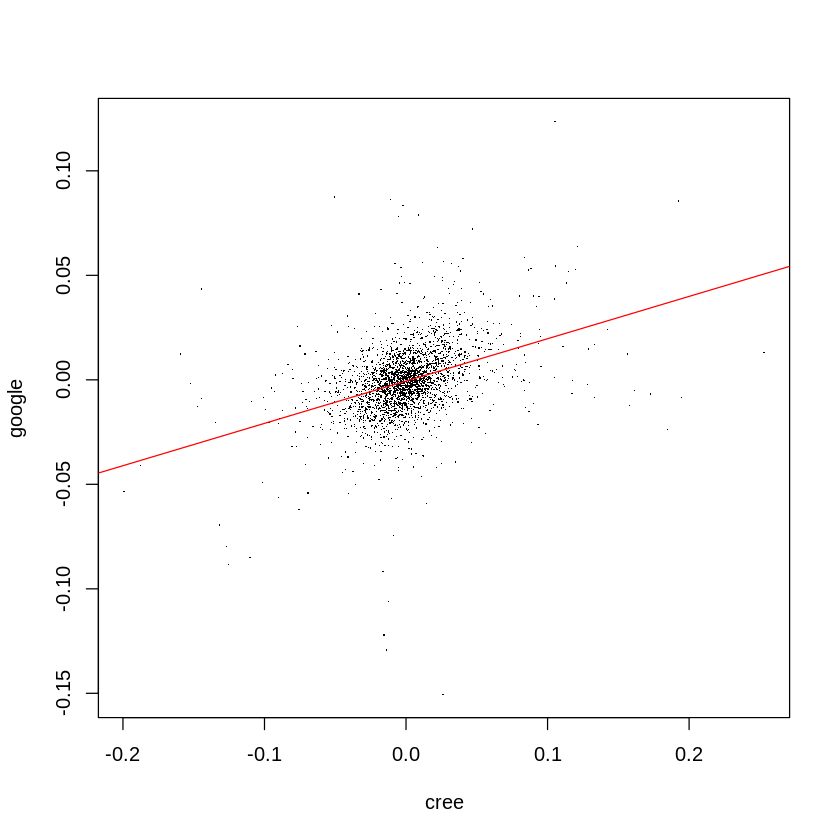

In [ ]:
plot(cree, google,pch='.')
abline(lm(google ~ cree), col='red', lwd=1)
cor(cree, google, method='spearman')

A t-copula should work. However, `VineCopula` package allows us to perform copula selection using BIC and AIC through the function `BiCopSelect()`

In [ ]:
    u <- pobs(as.matrix(cbind(cree,google)))[,1]
    v <- pobs(as.matrix(cbind(cree,google)))[,2]
    selectedCopula <- BiCopSelect(u,v,familyset=NA)
    selectedCopula

Bivariate copula: t (par = 0.43, par2 = 5.19, tau = 0.28) 

In [ ]:
selectedCopula$family
selectedCopula$par
selectedCopula$par2

[1] 2

[1] 0.4257175

[1] 5.192818

If familyset = NA (default), selection among all possible families is performed. If a vector of negative numbers is provided, selection among all but abs(familyset) families is performed. Coding of bivariate copula families: 0 = independence copula 1 = Gaussian copula 2 = Student t copula (t-copula) 3 = Clayton copula 4 = Gumbel copula 5 = Frank copula 6 = Joe copula

par is the correlation rho

par2 is the df of the t distribution

Fitting the suggested model using the `copula` package:

In [ ]:
t.cop <- tCopula(dim=2)
set.seed(500)
m <- pobs(as.matrix(cbind(cree,google)))
fit <- fitCopula(t.cop, m, method='ml')
# df	integer value specifying the number of degrees of freedom of the multivariate t distribution used to construct the t copulas.
# dim	the dimension of the copula.
t.cop
coef(fit)
(rho <- coef(fit)[1])
(df <- coef(fit)[2])

t-copula, dim. d = 2 
Dimension:  2 
Parameters:
  rho.1   = NA
  df      =  4

rho.1        df 
0.4257167 5.1928129

rho.1 
0.4257167

df 
5.192813

It is nice to see that the parameters of the fitted copula are the same as those suggested by the `BiCopSelect()` function.

In [ ]:
tCopula(dim=2, rho, df=df)

t-copula, dim. d = 2 
Dimension:  2 
Parameters:
  rho.1   = 0.4257167
  df      = 5.1928129

Let’s take a look at the density of the copula we have just estimated:

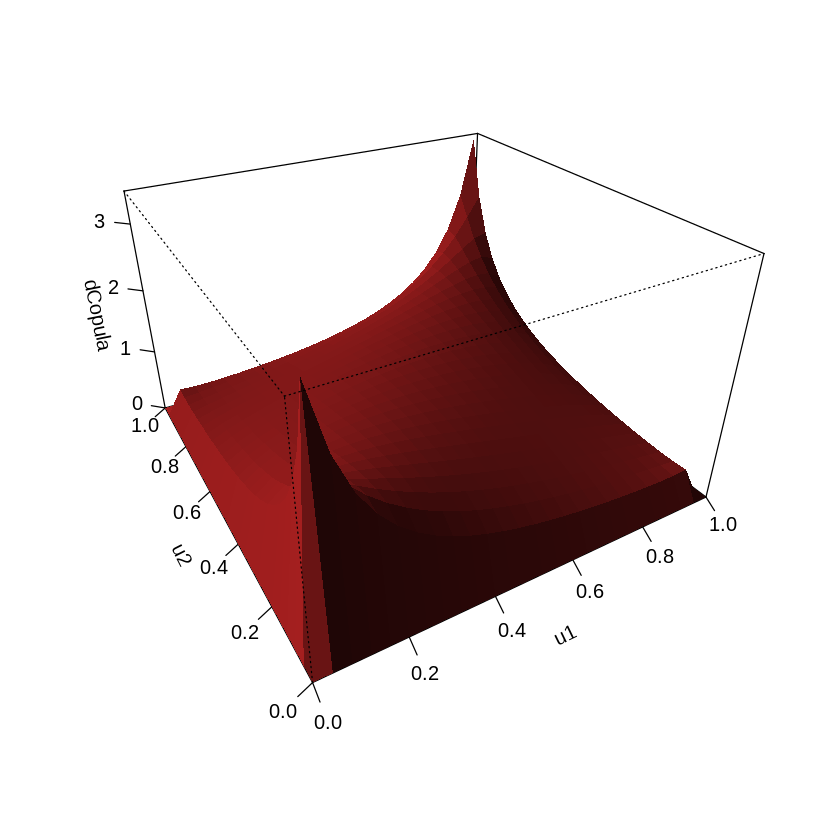

In [ ]:
persp(tCopula(dim=2, rho, df=df), dCopula, border=NA, shade=.75, col='firebrick')

Sampling from the copula:

0.98977751,0.69349252
0.32765493,0.11991498
0.10167525,0.09871016
0.05288842,0.01696333
0.50568584,0.23467365
0.34254213,0.17303319


1.0000000,0.3907335
0.3907335,1.0000000


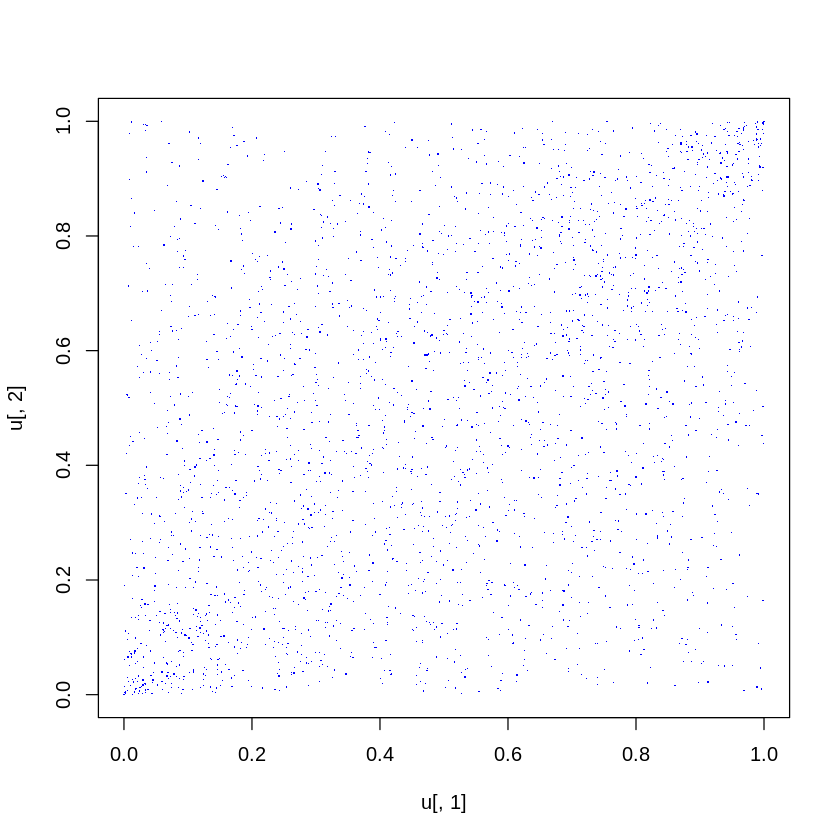

In [ ]:
u <- rCopula(nrow(m) , tCopula(dim=2, rho, df=df))
head(u)
plot(u[,1], u[,2],pch='.',col='blue')
cor(u, method='spearman')

The random samples from the copula look a little bit close to the independence case, but that is fine since the correlation between the returns is low.

Note that the generated samples have the same correlation as the data.
The t-copula emphasizes extreme results: it is usually good for modelling phenomena where there is high correlation in the extreme values (the tails of the distribution):

In [ ]:
cor(cbind(cree, google), method='spearman')

,cree,google
cree,1.0000000,0.3992292
google,0.3992292,1.0000000


Now we are facing the hard bit: modelling the marginals. We are going to assume normally distributed returns for simplicity even though it is well known to be a far from sound assumption. We therefore estimate the parameters of the marginals:

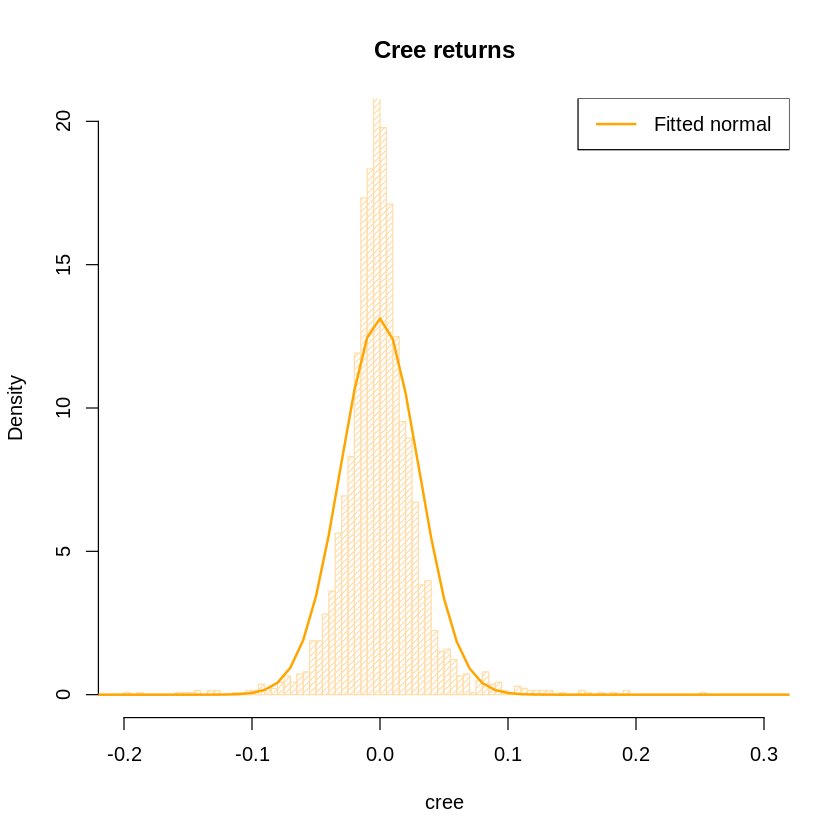

In [ ]:
cree_mu <- mean(cree)
cree_sd <- sd(cree)
google_mu <- mean(google)
google_sd <- sd(google)

hist(cree, breaks=80, main='Cree returns',freq=F,density=30, col='navajowhite',ylim=c(0,20),xlim=c(-0.2,0.3))
lines(seq(-0.5,0.5,0.01),dnorm(seq(-0.5,0.5,0.01), cree_mu, cree_sd), col='orange',lwd=2)
legend('topright',c('Fitted normal'),col=c('orange'),lwd=2)

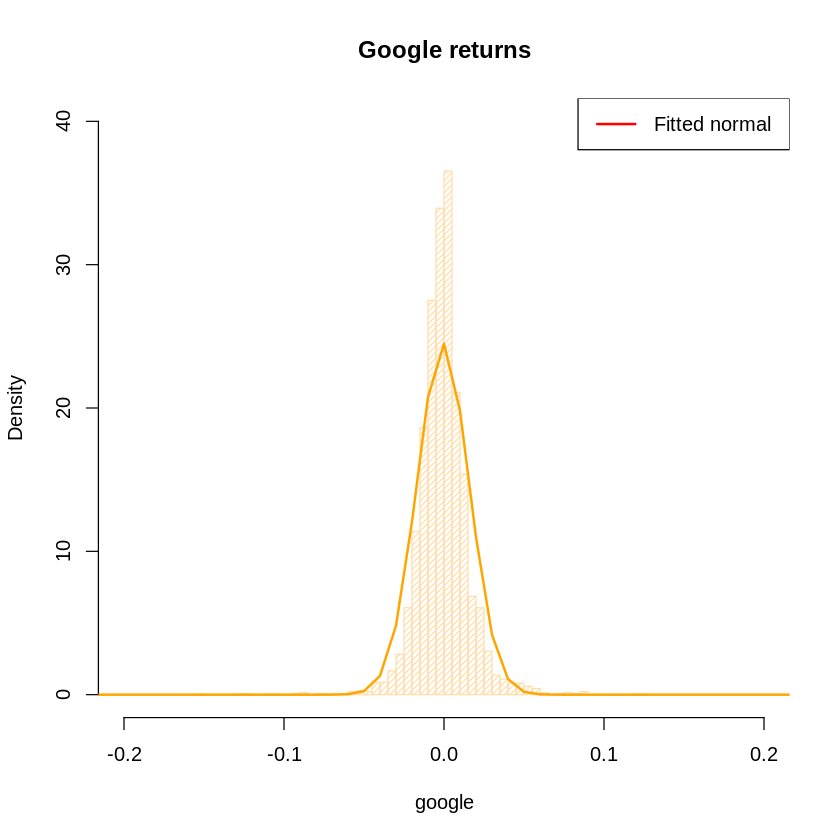

In [ ]:
hist(google,breaks=80,main='Google returns',density=30, col='navajowhite',freq=F,ylim=c(0,40),xlim=c(-0.2,0.2))
lines(seq(-0.5,0.5,0.01),dnorm(seq(-0.5,0.5,0.01),google_mu,google_sd), col='orange',lwd=2)
legend('topright',c('Fitted normal'),col=c('orange'),lwd=2)

Do not let the nice graphs fool you, under the assumptions for the distributions of the returns we are neglecting some extreme returns located in the tails of the distribution, but in this example we are interested in the joint behaviour, so that is what we are going to analyse soon.

Now we apply the copula in the `mvdc()` function and then use `rmvdc()` to get our simulated observations from the generated multivariate distribution. Finally, we compare the simulated results with the original data.

In [ ]:
copula_dist <- mvdc(copula=tCopula(rho,dim=2,df=df), margins=c("norm","norm"),
                    paramMargins=list(list(mean=cree_mu, sd=cree_sd),
                                      list(mean=google_mu, sd=google_sd)))
sim <- rMvdc(length(cree), copula_dist)

This is the final scatterplot of the data under the assumption of normal marginals and t-copula for the dependence structure:

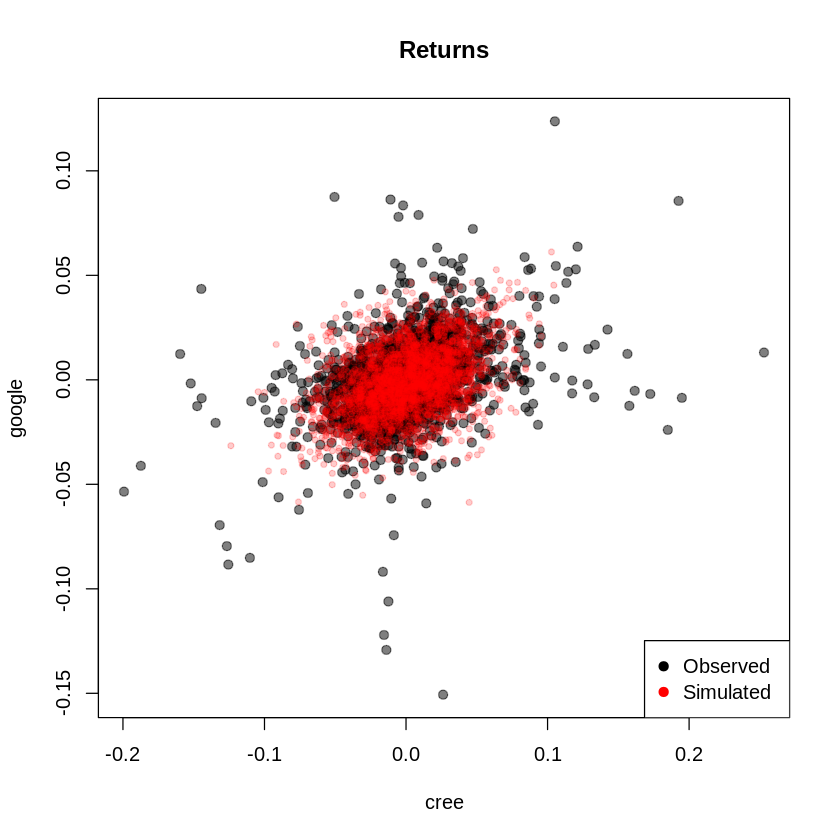

In [ ]:
plot(cree,google,main='Returns', pch=19, col=rgb(0,0,0,0.5))
points(sim[,1], sim[,2], col=rgb(1,0,0,.2), pch=20)
legend('bottomright',c('Observed','Simulated'), col=c('black','red'), pch=19)

As you can see, the t-copula leads to results close to the real observations, although there are fewer extreme returns than in the real data and we missed some of the most extreme result. If we were interested in modelling the risk associated with these stocks then this would be a major red flag to be addressed with further model calibration.

Since the purpose of this example is simply to show how to fit a copula and generate random observations using real data, we are going to stop here.

Just as a curiosity let me show you how the simulated values from the copula would have changed by tweaking the df parameter in the t-copula.

Let’s try $\text{df}=1$ and $\text{df}=8$:

[1] 0.3981243

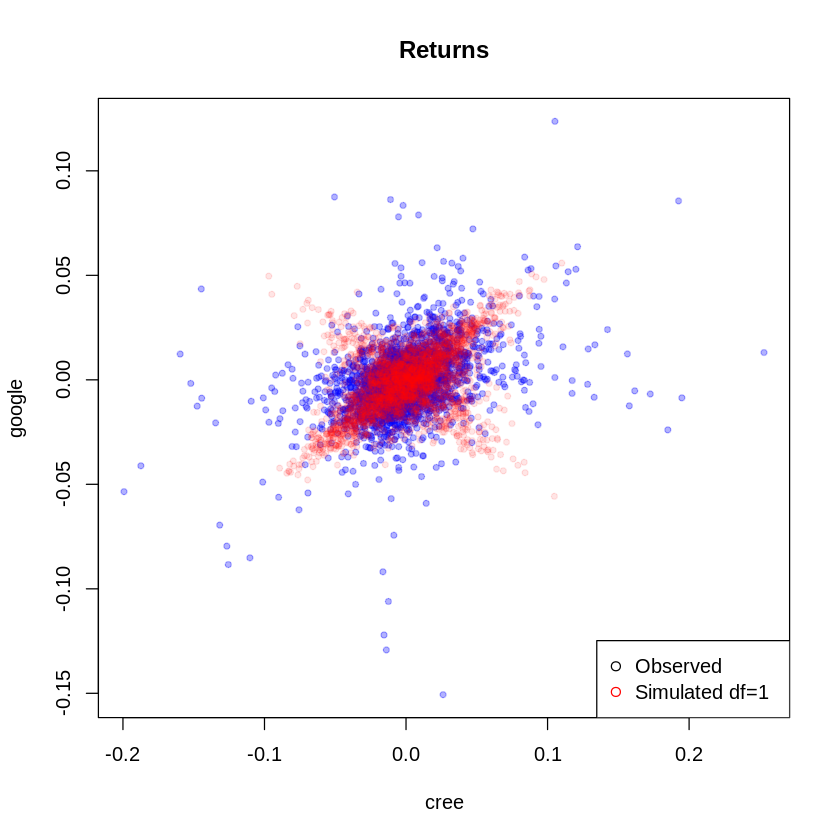

[1] 0.3963535

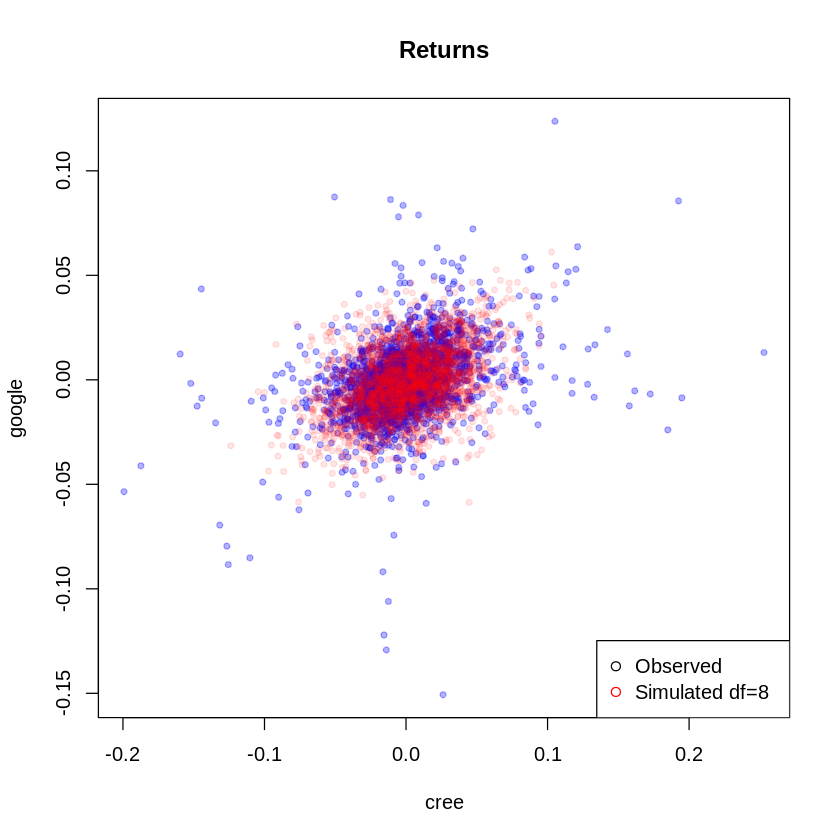

In [ ]:
set.seed(4258)
copula_dist <- mvdc(copula=tCopula(rho,dim=2,df=1), margins=c("norm","norm"),
                    paramMargins=list(list(mean=cree_mu, sd=cree_sd),
                                      list(mean=google_mu, sd=google_sd)))
sim <- rMvdc(length(cree), copula_dist)
plot(cree,google,main='Returns', pch=20, col=rgb(0,0,1,.3))
points(sim[,1],sim[,2], col=rgb(1,0,0,.1), pch=20)
legend('bottomright',c('Observed','Simulated df=1'),col=c('black','red'),pch=21)
cor(sim[,1],sim[,2],method='spearman')

copula_dist <- mvdc(copula=tCopula(rho,dim=2,df=8), margins=c("norm","norm"),
                    paramMargins=list(list(mean=cree_mu, sd=cree_sd),
                                      list(mean=google_mu, sd=google_sd)))
sim <- rMvdc(length(google), copula_dist)
plot(cree,google,main='Returns', pch=20, col=rgb(0,0,1,.3))
points(sim[,1],sim[,2], col=rgb(1,0,0,.1), pch=20)
legend('bottomright',c('Observed','Simulated df=8'),col=c('black','red'),pch=21)
cor(sim[,1],sim[,2],method='spearman')

Note how different are the dependence structures that we have obtained although Spearman’s Rho is similar.
Clearly the parameter df is very important in determining the shape of the distribution. As df increases, the t-copula tends to a gaussian copula.